- Leaving the account is deemed as a sell
- Entering the account is deemed as a buy

`ideas:`
- Volume of transactions in one day compared to the magnitude of price difference from MATIC token price. (Can increase the number of wallets that transaction data is being pulled from...)
- Magnitude for buying and selling in a day to the up or down movement of the Openn or CLose for the daily crypto price

In [1]:
from Historic_Crypto import HistoricalData as HD
import pandas as pd
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
import scipy


# Argument ---	   Description
- ticker ---	       supply the ticker information which you want to return (str).
- granularity ---	   please supply a granularity in seconds (60, 300, 900, 3600, 21600, 86400) (int).
- start_date ---	   a string in the format YYYY-MM-DD-HH-MM (str).
- end_date ---	   a string in the format YYYY-MM-DD-HH-MM (str). Optional, Default: Now
- verbose ---	       printing during extraction. Default: True

In [2]:
def etherScanAPICall(wallet_address):
    API_KEY = 'JATAZ8XWIBGBTY15YJJEABCDPIF8SCK7S3'
    MATIC_CONTRACT_ADDRESS = '0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0'
    # WALLET_ADDRESS = '0x9507c04b10486547584c37bcbd931b2a4fee9a41'
    url = 'https://api.etherscan.io/api?'

    parameters = {
        'module':'account',
        'action':'tokentx',
        'contractaddress':MATIC_CONTRACT_ADDRESS,
        'address':wallet_address,
        'page':'1',
        'offset':'10000',
        'startblock':'0',
        'endblock':'27025780',
        'sort':'asc',
        'apikey':API_KEY
    }

    responseJSON = requests.request("GET", url, params=parameters).json()

    print("# of Transactions:",len(responseJSON.get("result")))

    with open("transactionsResponse.json", "w") as write_file:
        json.dump(responseJSON, write_file, indent=4, sort_keys = True)

    return responseJSON


In [3]:
def etherScanAPI_MultiWallet_Call(listOfWalletAddresses):

    totalTransactionDataList = []

    for wallet in listOfWalletAddresses:
        walletTransactionData = etherScanAPICall(wallet)
        totalTransactionDataList = totalTransactionDataList + walletTransactionData.get("result")

    return totalTransactionDataList

In [4]:
def convert_UNIX_to_DateTime(unix):
    return datetime.utcfromtimestamp(int(unix)).strftime('%Y-%m-%d %H:%M:%S') # returns type str

In [5]:
def getDailyTransactionVolumeForSingleWallet(transactionData):
    dailyTransactionVolume = {}

    for transaction in transactionData.get('result'):
        timeStamp = convert_UNIX_to_DateTime(transaction.get("timeStamp"))
        timeStamp = timeStamp[0:10]
        if (timeStamp in dailyTransactionVolume):
            cnt = dailyTransactionVolume.get(timeStamp) + 1
            dailyTransactionVolume[timeStamp] = cnt
        else:
            dailyTransactionVolume[timeStamp] = 1

    return dailyTransactionVolume

In [71]:
def getDailyTransactionVolumeForListOfWallets(transactionData):
    dailyTransactionVolume = {}

    for transaction in transactionData:
        timeStamp = convert_UNIX_to_DateTime(transaction.get("timeStamp"))
        timeStamp = timeStamp[0:10]
        if (timeStamp in dailyTransactionVolume):
            cnt = dailyTransactionVolume.get(timeStamp) + 1
            dailyTransactionVolume[timeStamp] = cnt
        else:
            dailyTransactionVolume[timeStamp] = 1


    ordered_data = sorted(dailyTransactionVolume.items(), key = lambda x:datetime.strptime(x[0],'%Y-%m-%d'), reverse=False)

    # print(type(ordered_data))
    # print(type(dict(ordered_data)))
    # print(dict(ordered_data))

    return dict(ordered_data)

In [90]:
listOfWallets = [
    '0x9507c04b10486547584c37bcbd931b2a4fee9a41',
    '0x5666ed92c83af9dab61601c87bf7769ad57103f9',
    '0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0',
    '0xed28b1c47375cd23aa6428544f4feaeaf3ee4e7b'
]

In [91]:
# WALLET_ADDRESS = '0x9507c04b10486547584c37bcbd931b2a4fee9a41'
# rawTransactionData = etherScanAPICall('0x9507c04b10486547584c37bcbd931b2a4fee9a41')
# rawTransactionData = etherScanAPICall('0x5666ed92c83af9dab61601c87bf7769ad57103f9')

rawTransactionData = etherScanAPI_MultiWallet_Call(listOfWallets)

# single wallet: rawDailyTransactionVolume = getDailyTransactionVolumeForSingleWallet(rawTransactionData)
rawDailyTransactionVolume = getDailyTransactionVolumeForListOfWallets(rawTransactionData)

# del rawDailyTransactionVolume['2022-08-24']

#  

# of Transactions: 2506
# of Transactions: 728
# of Transactions: 499
# of Transactions: 3
411
{'2019-08-07': 1, '2019-08-17': 1, '2019-12-13': 1, '2019-12-16': 1, '2020-01-03': 1, '2020-02-05': 1, '2020-02-28': 1, '2020-04-25': 1, '2020-07-15': 1, '2020-08-01': 1, '2020-08-11': 1, '2020-08-17': 1, '2020-08-23': 1, '2020-08-26': 1, '2020-08-29': 2, '2020-10-11': 1, '2020-10-26': 1, '2020-12-16': 1, '2021-01-13': 1, '2021-03-03': 1, '2021-03-14': 2, '2021-03-16': 2, '2021-03-17': 1, '2021-04-10': 1, '2021-04-11': 1, '2021-04-23': 1, '2021-04-26': 1, '2021-04-27': 1, '2021-04-28': 1, '2021-05-01': 1, '2021-05-03': 1, '2021-05-04': 1, '2021-05-06': 1, '2021-05-10': 1, '2021-05-11': 1, '2021-05-12': 1, '2021-05-13': 3, '2021-05-14': 1, '2021-05-15': 1, '2021-05-19': 1, '2021-05-20': 1, '2021-05-22': 1, '2021-05-25': 1, '2021-05-26': 2, '2021-05-27': 3, '2021-05-28': 1, '2021-05-30': 1, '2021-06-02': 1, '2021-06-03': 1, '2021-06-05': 2, '2021-06-07': 1, '2021-06-10': 1, '2021-06-11': 1, '20

In [92]:
def getStartAndEndDate(transactionData):
    startDate = next(iter(transactionData)) 
    endDate = list(transactionData)[-1]
    return [startDate, endDate]

In [93]:
def getCryptoHistoricalData(token, startDate, endDate):
    data = HD(token,86400,startDate+"-00-00",endDate+"-00-00").retrieve_data()
    data.to_csv('tokenPriceData.csv')
    return data

In [94]:
startAndEndDate = getStartAndEndDate(rawDailyTransactionVolume)

rawTokenData = getCryptoHistoricalData('MATIC-USD', startAndEndDate[0], startAndEndDate[1])

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'MATIC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2019-08-07T00:00:00
Provisional End: 2020-06-02T00:00:00
Data for chunk 1 of 5 extracted
CoinBase Pro API did not have available data for 'MATIC-USD' beginning at 2019-08-07-00-00.  
                        Trying a later date:'2019-08-07T00:00:00'
Provisional Start: 2020-06-02T00:00:00
Provisional End: 2021-03-29T00:00:00
Data for chunk 2 of 5 extracted
Provisional Start: 2021-03-29T00:00:00
Provisional End: 2022-01-23T00:00:00


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Data for chunk 3 of 5 extracted
Provisional Start: 2022-01-23T00:00:00
Provisional End: 2022-11-19T00:00:00
Data for chunk 4 of 5 extracted
Provisional Start: 2022-11-19T00:00:00
Provisional End: 2023-09-15T00:00:00
Data for chunk 5 of 5 extracted


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


In [95]:
def getRangePrices(tokenData):
    highPrices = list(tokenData["high"])
    lowPrices = list(tokenData["low"])
    rangePrices = [a - b for a, b in zip(highPrices, lowPrices)]
     
    dateTimes = tokenData.index.tolist()

    datesToRangePrice = {}
    cnt = 0

    for dateTime in dateTimes:
        datesToRangePrice[str(dateTime)[0:10]] = rangePrices[cnt]
        cnt += 1

    # print(datesToRangePrice)
    return datesToRangePrice

In [96]:
dailyTokenPriceAction = getRangePrices(rawTokenData)

In [97]:
def alignTransactionsToPrice(transactions, prices):

    newTransactions = {}

    for key in prices.keys():
        if (key in transactions):
            newTransactions[key] = transactions.get(key)
        else:
            newTransactions[key] = 0

    # print(len(prices))
    # print(len(transactions))
    # print(len(newTransactions))
    # print(newTransactions)

    return newTransactions

In [98]:
dailyTransactionVolume = alignTransactionsToPrice(rawDailyTransactionVolume, dailyTokenPriceAction)

In [99]:
def alignPriceToTransactions(transactions, prices):

    newRangePrices = {}

    for key in transactions.keys():
        if (key in prices):
            newRangePrices[key] = prices.get(key)

    # print(len(prices))
    # print(len(transactions))
    # print(len(newRangePrices))
    # print(newRangePrices)

    return newRangePrices

In [100]:
dailyTokenPriceAction = alignPriceToTransactions(rawDailyTransactionVolume, dailyTokenPriceAction)

In [101]:
def createPlotFromDict(dict):
    keys = dict.keys()
    values = dict.values()
    # plt.bar(keys, values)
    plt.plot(keys, values)
    # plots bar chart of keys (x) against values (y)

In [102]:
def printDataSet(data):
    print("Data Length:", len(data))
    print(str(data)+"\n")

In [103]:
printDataSet(rawDailyTransactionVolume)
printDataSet(dailyTokenPriceAction)

Data Length: 411
{'2019-08-07': 1, '2019-08-17': 1, '2019-12-13': 1, '2019-12-16': 1, '2020-01-03': 1, '2020-02-05': 1, '2020-02-28': 1, '2020-04-25': 1, '2020-07-15': 1, '2020-08-01': 1, '2020-08-11': 1, '2020-08-17': 1, '2020-08-23': 1, '2020-08-26': 1, '2020-08-29': 2, '2020-10-11': 1, '2020-10-26': 1, '2020-12-16': 1, '2021-01-13': 1, '2021-03-03': 1, '2021-03-14': 2, '2021-03-16': 2, '2021-03-17': 1, '2021-04-10': 1, '2021-04-11': 1, '2021-04-23': 1, '2021-04-26': 1, '2021-04-27': 1, '2021-04-28': 1, '2021-05-01': 1, '2021-05-03': 1, '2021-05-04': 1, '2021-05-06': 1, '2021-05-10': 1, '2021-05-11': 1, '2021-05-12': 1, '2021-05-13': 3, '2021-05-14': 1, '2021-05-15': 1, '2021-05-19': 1, '2021-05-20': 1, '2021-05-22': 1, '2021-05-25': 1, '2021-05-26': 2, '2021-05-27': 3, '2021-05-28': 1, '2021-05-30': 1, '2021-06-02': 1, '2021-06-03': 1, '2021-06-05': 2, '2021-06-07': 1, '2021-06-10': 1, '2021-06-11': 1, '2021-06-13': 1, '2021-06-14': 1, '2021-06-17': 1, '2021-06-18': 1, '2021-06-19':

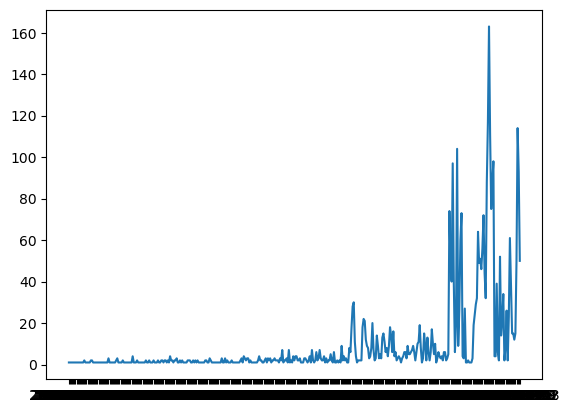

In [104]:
createPlotFromDict(rawDailyTransactionVolume)

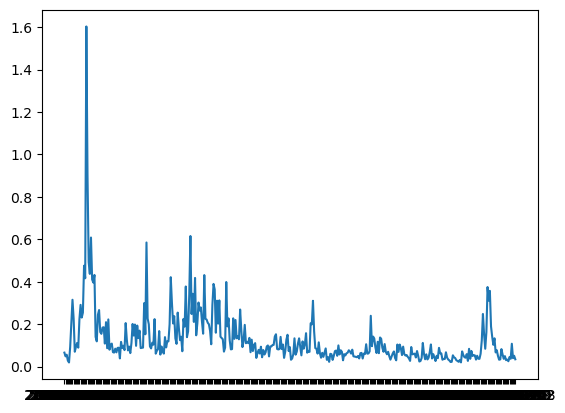

In [105]:
createPlotFromDict(dailyTokenPriceAction)

In [106]:
def performLinearRegression(data1, data2):
    a = list(data1.values())
    b = list(data2.values())

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(a, b)
    
    print("R_value:",r_value**2)
    print("P_value:",p_value)

In [107]:
performLinearRegression(rawDailyTransactionVolume, dailyTokenPriceAction)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 411 and the array at index 1 has size 391